In [1]:
train_full = pd.read_pickle('./train_full.pkl')

In [2]:
train_full.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,month,day
0,11016594,0.0276,2016-01-01,1,NaN,NaN,2.0,3.0,NaN,4,...,122754.0,360170.0,2015,237416.0,6735.88,NaN,NaN,6.03711e+13,1,1
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,346458.0,585529.0,2015,239071.0,10153.02,NaN,NaN,NaN,1,1
2,12098116,-0.0040,2016-01-01,1,NaN,NaN,3.0,2.0,NaN,4,...,61994.0,119906.0,2015,57912.0,11484.48,NaN,NaN,6.03746e+13,1,1
3,12643413,0.0218,2016-01-02,1,NaN,NaN,2.0,2.0,NaN,4,...,171518.0,244880.0,2015,73362.0,3048.74,NaN,NaN,6.0373e+13,1,2
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,169574.0,434551.0,2015,264977.0,5488.96,NaN,NaN,6.05904e+13,1,2


#### A lambda function to filter the columns which have less than 25% missing values

In [3]:
check_null = lambda x: x.isnull().sum()/float(len(train_full)) < 0.25

In [4]:
low_missing_values_cols = [col for col in train_full.columns if check_null(train_full[col])]

In [5]:
train_low_missing_values_cols_float = train_full[low_missing_values_cols].select_dtypes('float')

In [6]:
train_low_missing_values_cols_object = train_full[low_missing_values_cols].select_dtypes('object')

In [7]:
train_low_missing_values_cols_object.fips.value_counts()

6037.0    109270
6059.0     45136
6111.0     13448
Name: fips, dtype: int64

In [11]:
train_low_missing_values_cols_object['logerror'] = train_full.logerror

In [12]:
import seaborn as sns

In [14]:
train_low_missing_values_cols_object['errors'] = np.exp(train_low_missing_values_cols_object.logerror)

#### Looks like the errors are distributed across the different counties equally although we see the outliers more for the county with fips code 6037

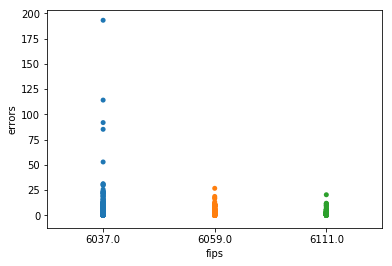

In [20]:
sns.stripplot(x="fips", y="errors", data=train_low_missing_values_cols_object)

In [21]:
for county in train_low_missing_values_cols_object.fips.unique():
    print county,":", np.median(train_low_missing_values_cols_object[train_low_missing_values_cols_object.fips == county]['errors'])

6037.0 : 1.00601803605
6059.0 : 1.00679106549
6111.0 : 1.00688569675
nan : nan


#### From the data dictionary it's pretty obvious that more than 1 pair of columns are nearly identical save few rows.
#### The following code cells try to clean up the data by removing/merging the duplicate columns.

In [23]:
for col in train_full[low_missing_values_cols].select_dtypes('object'):
    print col,":",len(train_full[col].unique())

parcelid : 165210
fips : 4
propertycountylandusecode : 91
propertylandusetypeid : 15
rawcensustractandblock : 57812
regionidcity : 179
regionidcounty : 4
regionidzip : 391
yearbuilt : 139
assessmentyear : 3
censustractandblock : 57545
month : 12
day : 31


#### Looks like `regionidcounty` and `fips` are identical and mean the same

In [24]:
for val in train_full['regionidcounty'].unique():
    print train_full[train_full.regionidcounty == val]['fips'].unique()

[6037.0]
[6059.0]
[6111.0]
[]


In [25]:
train_full[['regionidcounty','fips']].isnull().sum()

regionidcounty    34
fips              34
dtype: int64

#### `censustractandblock` and `rawcensustractandblock` are identical - the former has 6 zeroes appended - that's the only difference. I removed the zeroes to make the fields equal

In [29]:
pd.set_option('display.float_format', lambda x: '%.13f' % x)

In [30]:
train_full[['censustractandblock','rawcensustractandblock']].head(1)

,censustractandblock,rawcensustractandblock
0,60371066461001.0000000000000,60371066.4610010012984


In [31]:
import math

In [32]:
train_full.censustractandblock = train_full.censustractandblock/math.pow(10,6)

In [33]:
train_full[['censustractandblock','rawcensustractandblock']].head(1)

,censustractandblock,rawcensustractandblock
0,60371066.4610010012984,60371066.4610010012984


From the data dictionary we find that the field, `censustractandblock` is a categorical variable consisting of a combination of ids:
    1. censustract
    2. blockid
    3. blockgroup assignment id

The following code cells attempt to break down the field into multiple ids

`censustract` attempts to capture the 'censustract+block' part of the id (the group of numbers before the decimal)  

In [36]:
train_full['censustract'] = [np.floor(row.rawcensustractandblock) if np.isnan(row.censustractandblock) else np.floor(row.censustractandblock) for i,row in train_full.iterrows()]

In [37]:
train_full[['censustractandblock','rawcensustractandblock','censustract']].head(10)

,censustractandblock,rawcensustractandblock,censustract
0,60371066.4610010012984,60371066.4610010012984,60371066.0000000000000
1,NaN,60590524.2220240011811,60590524.0000000000000
2,60374638.0030039995909,60374638.0030040070415,60374638.0000000000000
3,60372963.0020020008087,60372963.0020020008087,60372963.0000000000000
4,60590423.3810060024261,60590423.3810060024261,60590423.0000000000000
5,60376210.0440059974790,60376210.0440060049295,60376210.0000000000000
6,60375416.0530069991946,60375416.0530069917440,60375416.0000000000000
7,61110031.0020729973912,61110031.0020729973912,61110031.0000000000000
8,60590423.1510180011392,60590423.1510189920664,60590423.0000000000000
9,60590626.4830150008202,60590626.4830050021410,60590626.0000000000000


`blockid` attempts to separate the last 4 digits of censustract 

In [38]:
train_full['blockid'] = [row.censustract - (row.fips * math.pow(10,4)) for i,row in train_full.iterrows()]

In [39]:
train_full[['censustractandblock','rawcensustractandblock','censustract','blockid']].head(10)

,censustractandblock,rawcensustractandblock,censustract,blockid
0,60371066.4610010012984,60371066.4610010012984,60371066.0000000000000,1066.0000000000000
1,NaN,60590524.2220240011811,60590524.0000000000000,524.0000000000000
2,60374638.0030039995909,60374638.0030040070415,60374638.0000000000000,4638.0000000000000
3,60372963.0020020008087,60372963.0020020008087,60372963.0000000000000,2963.0000000000000
4,60590423.3810060024261,60590423.3810060024261,60590423.0000000000000,423.0000000000000
5,60376210.0440059974790,60376210.0440060049295,60376210.0000000000000,6210.0000000000000
6,60375416.0530069991946,60375416.0530069917440,60375416.0000000000000,5416.0000000000000
7,61110031.0020729973912,61110031.0020729973912,61110031.0000000000000,31.0000000000000
8,60590423.1510180011392,60590423.1510189920664,60590423.0000000000000,423.0000000000000
9,60590626.4830150008202,60590626.4830050021410,60590626.0000000000000,626.0000000000000


`blockgroup` captures the values after the decimal

In [40]:
train_full['blockgroup'] = [np.modf(row.rawcensustractandblock)[0] if np.isnan(row.censustractandblock) else np.modf(row.censustractandblock)[0] for i,row in train_full.iterrows()]

In [41]:
train_full[['censustractandblock','rawcensustractandblock','censustract','blockid','blockgroup']].head(10)

,censustractandblock,rawcensustractandblock,censustract,blockid,blockgroup
0,60371066.4610010012984,60371066.4610010012984,60371066.0000000000000,1066.0000000000000,0.4610010012984
1,NaN,60590524.2220240011811,60590524.0000000000000,524.0000000000000,0.2220240011811
2,60374638.0030039995909,60374638.0030040070415,60374638.0000000000000,4638.0000000000000,0.0030039995909
3,60372963.0020020008087,60372963.0020020008087,60372963.0000000000000,2963.0000000000000,0.0020020008087
4,60590423.3810060024261,60590423.3810060024261,60590423.0000000000000,423.0000000000000,0.3810060024261
5,60376210.0440059974790,60376210.0440060049295,60376210.0000000000000,6210.0000000000000,0.0440059974790
6,60375416.0530069991946,60375416.0530069917440,60375416.0000000000000,5416.0000000000000,0.0530069991946
7,61110031.0020729973912,61110031.0020729973912,61110031.0000000000000,31.0000000000000,0.0020729973912
8,60590423.1510180011392,60590423.1510189920664,60590423.0000000000000,423.0000000000000,0.1510180011392
9,60590626.4830150008202,60590626.4830050021410,60590626.0000000000000,626.0000000000000,0.4830150008202


* `regionidzip` indicates the zipcode of the property - so intuitively it should map distinctly to one particular county
* However we see there are few zipcodes which belong to more than 1 county and `fips = 6037` is constant in all of them - 
* 6037 is also the middle of the 3 countries geographically - this just makes sense as these properties must have been located
on the order of the counties thus leading to more than 1 county

In [42]:
train_full[['regionidzip','fips']].head()

,regionidzip,fips
0,96370.0000000000000,6037.0000000000000
1,96962.0000000000000,6059.0000000000000
2,96293.0000000000000,6037.0000000000000
3,96222.0000000000000,6037.0000000000000
4,96961.0000000000000,6059.0000000000000


In [43]:
for val in train_full['regionidzip'].unique():
    if len(train_full[train_full.regionidzip == val]['fips'].unique()) != 1:
        print val, ":", train_full[train_full.regionidzip == val]['fips'].unique()

96190.0 : [6037.0 6059.0]
96384.0 : [6037.0 6111.0]
96183.0 : [6059.0 6037.0]
96186.0 : [6059.0 6037.0]
96385.0 : [6111.0 6037.0]
96346.0 : [6037.0 6111.0]
96342.0 : [6037.0 6111.0]
96116.0 : [6037.0 6111.0]
96339.0 : [6037.0 6111.0]
nan : []


We see the same pattern for `regionidcity` and `regionidneighborhood`

In [44]:
for val in train_full['regionidcity'].unique():
    if len(train_full[train_full.regionidcity == val]['fips'].unique()) != 1:
        print val, ":", train_full[train_full.regionidcity == val]['fips'].unique()

12447.0 : [6037.0 6111.0]
5465.0 : [6037.0 6059.0]
41673.0 : [6037.0 6111.0]
34278.0 : [6111.0 6037.0]
nan : []
15237.0 : [6059.0 6037.0]
10608.0 : [6059.0 6037.0]
9840.0 : [6037.0 6111.0]
18874.0 : [6059.0 6037.0]
44833.0 : [6059.0 6037.0]
18875.0 : [6037.0 6059.0]
12520.0 : [6037.0 6111.0]
54352.0 : [6059.0 6037.0]


In [45]:
for val in train_full['regionidneighborhood'].unique():
    if len(train_full[train_full.regionidneighborhood == val]['fips'].unique()) != 1:
        print val, ":", train_full[train_full.regionidneighborhood == val]['fips'].unique()

nan : []
37835.0 : [6037.0 6111.0]


#### Each `propertylandusetypeid` appears to be mapped to multiple `propertycountylandusecode` - so I do not observe any evidence of duplicate in these 2 columns even thpough their field descriptions are pretty similar

In [158]:
for val in train_full['propertylandusetypeid'].unique():
    if len(train_full[train_full.propertylandusetypeid == val]['propertycountylandusecode'].unique()) != 1:
        print val, ":", train_full[train_full.propertylandusetypeid == val]['propertycountylandusecode'].unique()

261.0 : ['0100' '1' '122' '0104' '0101' '1111' '1110' '010V' '010G' '0103' '0111'
 '010M' '0108' '1014' '1112' '0109' '1011' '0102' '0110' '0130' '8800'
 '0114' '010' '0131' '0113' '0133' '0105' '0141' '0115' '010L']
266.0 : ['010C' '1129' '34' '1' '010E' '01DC' '012C' '01HC' '010H' '010V' '01DD'
 '040V' nan '01HE']
246.0 : ['0200' '38' '1210' '0201' '1222' '0210' '020G' '020M' '200' '0204' '0203'
 '020E']
263.0 : ['0700' '1116' '73' '070D' '0']
269.0 : ['010D' '010V' '1014' '1' '1011' '100V' '1012']
248.0 : ['0400' '96' '1410' '1432' '0401' '040A' '040V' '1421' '1420' '040G' '040B']
247.0 : ['0300' '135' '1310' '1321' '0303' '1333' '030G' '0301']
275.0 : ['1117' '1120']
260.0 : ['010V' '105']
31.0 : ['1720' '1210' '1722' '6050' '0200']
264.0 : ['012D' '012E']
nan : []
